# Walk through all streets in a city

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Problem description

Find the shortest way going through all streets from a set of streets? This problem is known as the *Route inspection problem*.

## Data

[Seattle streets](https://data.seattle.gov/dataset/Street-Network-Database/afip-2mzr/data) from [data.seattle.gov](https://data.seattle.gov/)

### Read the data

In [ ]:
import shapefile, os
if os.path.exists("Street_Network_Database/WGS84/Street_Network_Database.shp"):
    rshp = shapefile.Reader("Street_Network_Database/WGS84/Street_Network_Database.shp")
    shapes = rshp.shapes()
    records = rshp.records()
else:
    from pyensae.datasource import download_data
    files = download_data("WGS84_seattle_street.zip")
    rshp = shapefile.Reader("Street_Network_Database.shp")
    shapes = rshp.shapes()
    records = rshp.records()    

In [ ]:
shapes[0].__dict__

{'bbox': [-122.34721334599999, 47.46946425100003, -122.346519546, 47.469471997000035],
 'parts': [0],
 'points': [[-122.34651954599997, 47.46947199700003],
  [-122.34721334599999, 47.46946425100003]],
 'shapeType': 3}

In [ ]:
{k[0]:v for k,v in zip(rshp.fields[1:], records[0])}

{'ACCESS_COD': 1,
 'AGENCY_COD': 1,
 'ARTERIAL_C': 0,
 'CITYCODE': 0,
 'COMPKEY': 0,
 'COMPTYPE': 0,
 'DIVIDED_CO': 1,
 'F_INTR_ID': 21642,
 'GIS_SEG_LE': '1.71624048000e+002',
 'LEGALLOC_C': 1,
 'L_ADRS_FRO': 977,
 'L_ADRS_TO': 999,
 'L_CITY': 'BURIEN',
 'L_STATE': 'WA',
 'L_ZIP': '98166',
 'ORD_PRE_DI': 'SW',
 'ORD_STNAME': 'SW 149TH ST',
 'ORD_STREET': '149TH',
 'ORD_STRE_1': 'ST',
 'ORD_SUF_DI': b'  ',
 'R_ADRS_FRO': 976,
 'R_ADRS_TO': 998,
 'R_CITY': 'BURIEN',
 'R_STATE': 'WA',
 'R_ZIP': '98166',
 'SEGMENT_TY': 1,
 'SHAPE_Leng': '6.93843239173e-004',
 'SNDSEG_UPD': '20040519',
 'SND_FEACOD': 1,
 'SND_ID': 37898,
 'STNAME_ID': 2569,
 'STRUCTURE_': 1,
 'ST_CODE': 0,
 'T_INTR_ID': 21641,
 'UNITID': '0',
 'UNITID2': '0',
 'VEHICLE_US': 1}

### Display the streets

In [ ]:
streets5 = list(zip(records[:5], shapes[:5]))
streets5[2][1].points

[[-122.31554790099995, 47.511287922000065],
 [-122.31553241799998, 47.51120351700007],
 [-122.31552978999997, 47.51118938700006],
 [-122.31546052299996, 47.51092530900007],
 [-122.31537415499997, 47.510596031000034],
 [-122.31534125099995, 47.51046084500007],
 [-122.31532328399999, 47.51032437400005]]

In [ ]:
from random import randint

import folium
c = streets5[0][1]
print(c.bbox)
map_osm = folium.Map(location=[c.bbox[1], c.bbox[0]], zoom_start=9)
for rec, shape in streets5:
    d = {k[0]:v for k,v in zip(rshp.fields[1:], rec)}
    map_osm.add_child(folium.Marker([shape.points[0][1], shape.points[0][0]], popup=str(d)))
    map_osm.add_child(folium.PolyLine(locations=shape.points, latlon=False, weight=10))
from pyensae.notebook_helper import folium_html_map
folium_html_map(map_osm, width="60%")

[-122.34721334599999, 47.46946425100003, -122.346519546, 47.469471997000035]


<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x1a22caf7e80>

## Find connected streets

In [ ]:
street0 = streets5[0][1].points
street0

[[-122.34651954599997, 47.46947199700003],
 [-122.34721334599999, 47.46946425100003]]

In [ ]:
def connect_streets(st1, st2):
    a1, b1 = st1[0], st1[-1]
    a2, b2 = st2[0], st2[-1]
    connect = []
    if a1 == a2:
        connect.append((0, 0))
    if a1 == b2:
        connect.append((0, 1))
    if b1 == a2:
        connect.append((1, 0))
    if b1 == b2:
        connect.append((1, 1))
    return tuple(connect) if connect else None

neighbours = []
for i, street in enumerate(shapes):
    points = street.points
    con = connect_streets(street0, points)
    if con:
        neighbours.append(i)
        
neighbours    

[0, 107, 1670, 9989, 11274, 12783]

In [ ]:
import folium
c = shapes[neighbours[0]]
map_osm = folium.Map(location=[c.bbox[1], c.bbox[0]], zoom_start=15)
for index in neighbours:
    rec, shape = records[index], shapes[index]
    map_osm.add_child(folium.Marker([shape.points[0][1], shape.points[0][0]], popup=str(index)))
    map_osm.add_child(folium.PolyLine(locations=shape.points, latlon=False, weight=10))
from pyensae.notebook_helper import folium_html_map
folium_html_map(map_osm, width="50%")

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x1a22cb2dc88>

## Extraction of all streets in a short perimeter

In [ ]:
from shapely.geometry import Point, LineString

def enumerate_close(x, y, shapes, th=None):
    p = Point(x,y)
    for i, shape in enumerate(shapes):
        obj = LineString(shape.points)
        d = p.distance(obj)
        if th is None or d <= th:
            yield d, i

x, y = shapes[0].points[0]
closes = list(enumerate_close(x, y, shapes))
closes.sort()
closes[:10]

[(0.0, 0),
 (0.0, 1670),
 (0.0, 9989),
 (0.0, 12783),
 (0.0006938432391730961, 107),
 (0.0006938432391730961, 11274),
 (0.0009050591972649863, 9118),
 (0.0009122767287444535, 6488),
 (0.001006818609911273, 1101),
 (0.001006818609911273, 2808)]

In [ ]:
import folium
from ensae_projects.data.data_geo_streets import folium_html_street_map
folium_html_street_map([_[1] for _ in closes[:20]], shapes, html_width="50%", zoom_start=15)

<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x1a22d0afd30>

In [ ]:
def complete_subset_streets(subset, shapes):
    extension = []
    for i, shape in enumerate(shapes):
        add = []
        for s in subset:
            to = shapes[s]
            if s != i:
                con = connect_streets(shapes[s].points, shapes[i].points)
                if con is not None:
                    add.extend([_[1] for _ in con])
        if len(set(add)) == 2:
            extension.append(i)
    return extension

subset = [index for dist, index in closes[:20]]
newset = set(subset + complete_subset_streets(subset, shapes))

print(list(sorted(newset)))
folium_html_street_map(newset, shapes, html_width="50%", zoom_start=15)

[0, 107, 1003, 1101, 1670, 2418, 2803, 2808, 3353, 4553, 4994, 6265, 6488, 6712, 8378, 9118, 9989, 11274, 11394, 12783, 15023, 17680, 29114, 30370]


<pyensae.notebook_helper.folium_helper.folium_html_map.<locals>.CustomFoliumMap at 0x1a22d19ff60>

In [ ]:
from ensae_projects.data.data_geo_streets import build_streets_vertices
vertices, edges = build_streets_vertices(newset, shapes)
vertices[:3], edges[:3]

([(-122.34991548199997, 47.46763155800005),
  (-122.34991155699998, 47.468532819000075),
  (-122.349907514, 47.469446668000046)],
 [(10, 7), (5, 4), (4, 0)])

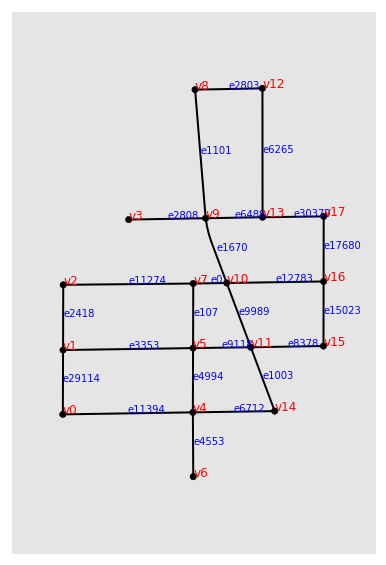

In [ ]:
from ensae_projects.data.data_geo_streets import plot_streets_network
plot_streets_network(newset, edges, vertices, shapes, figsize=(10,10))